# Processing of ECG signals

This document highlights the process of signal processing used in this project. The script used to run the actual processing can be found at scripts/processing.py. This notebook is meant to highlight the process and reasoning behind using certain methods.



## 0. Logistics

### 0.1 Loading the files 
The following cell block loads in all the records from the test directory into a list. 

In [89]:
import os # for handling loading in the files

In [90]:
base_path = "../physionet.org/files/ecg-arrhythmia/1.0.0/WFDBRecords/01/010"
recordPath = []


for root, dirs, files in os.walk(base_path):

    files.sort()

    for file in files:
        if file.endswith(".mat"):

            record_name = os.path.splitext(file)[0]

            record_path = os.path.join(root, record_name)


            recordPath.append(record_path) # has all record paths



### 0.2 Getting the signal data

The next step is to get the signal data. For that wfdb is used which is a standard library for looking at ECG signals.

In [91]:
from wfdb.io import rdrecord
from wfdb import Record

In [92]:
records:list[Record] = []
sf = 0
for r in recordPath:
    record = rdrecord(
r
    )
    if sf == 0:
        sf = record.fs
    elif sf != record.fs:
        raise ValueError("Sampling frequency of signals do not match")
    records.append(record)

### 0.3 Writing Processed signal files

Once again we use the wfdb library for this task. This can be further reviewed in the script file.

### 0.4  Extracting comments from the file

The conditions names are written with a snomed code so to implement labels for our model a function was made that converts the code to a condition name. Details of this function can be found in the code block bellow. This step is skipped here because it is done when writing to the file can be seen in the script file.

In [93]:
import pandas as pd

SNOMED = pd.read_csv('../physionet-data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/ConditionNames_SNOMED-CT.csv')


mapping = pd.Series(SNOMED['Acronym Name'].values, index=SNOMED['Snomed_CT'].astype(str)).to_dict()


def parseConditions(comments):


    for data in comments:
        if data.startswith("Dx:"):
            dx_codes = data.split(": ")[1].split(",")

            mapped = [mapping.get(dx, f"Unknown Dx: {dx}") for dx in dx_codes]
            return mapped



In [94]:
from matplotlib import pyplot as plt

#helper functions to plot visualisations
def plot(a,b):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)  
    plt.plot(a, label='Before')
    plt.title('Before')

    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)  
    plt.plot(b,label='After')
    plt.title('After')

    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plotLeads(signal:pd.DataFrame,big=False):
    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    x=9 if not big else 16
    y=6 if not big else 12
    plt.figure(figsize=(x, y))


    for i, lead in enumerate(index):
        plt.subplot(4, 3, i + 1)  
        plt.plot(signal[lead][:300]) 
        plt.title(lead)           
        plt.grid(True)            


    plt.tight_layout()
    plt.show()

## 1. Normalisation of signal

Before removing noise the first step would be normalise the signal, luckily wfbd has this built in so we just use the function. 


In [95]:
record=records[0] #first signal for testing, stored as a pandas dataframe
fs=record.fs # sampling requency fo record 

In [96]:
import wfdb.processing as wd


In [97]:
record.p_signal = wd.normalize_bound(record.p_signal)


### 2. Baseline Wander Removal

Second noise removal is the baseline wander removal of the signal. This has been done with a high pass filter. Scipy signal library was used to achieve this task.

In [98]:

from scipy import signal

In [99]:
def removeBaselineWander(ecg_signal:pd.DataFrame,sf):
    
    sampling_rate = sf  
    cutoff_frequency = 0.8
    nyquist_rate = sampling_rate / 2

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 

    b, a = signal.butter(1, cutoff_frequency / nyquist_rate, btype='highpass')
    for i in index:    
        ecg_signal[i] = signal.filtfilt(b, a, ecg_signal[i])
    return ecg_signal

In [100]:
recordDf=record.to_dataframe()# converting for easier manipulation
record.fillna(0,inplace=True)

filtered=removeBaselineWander(recordDf.copy(),fs)

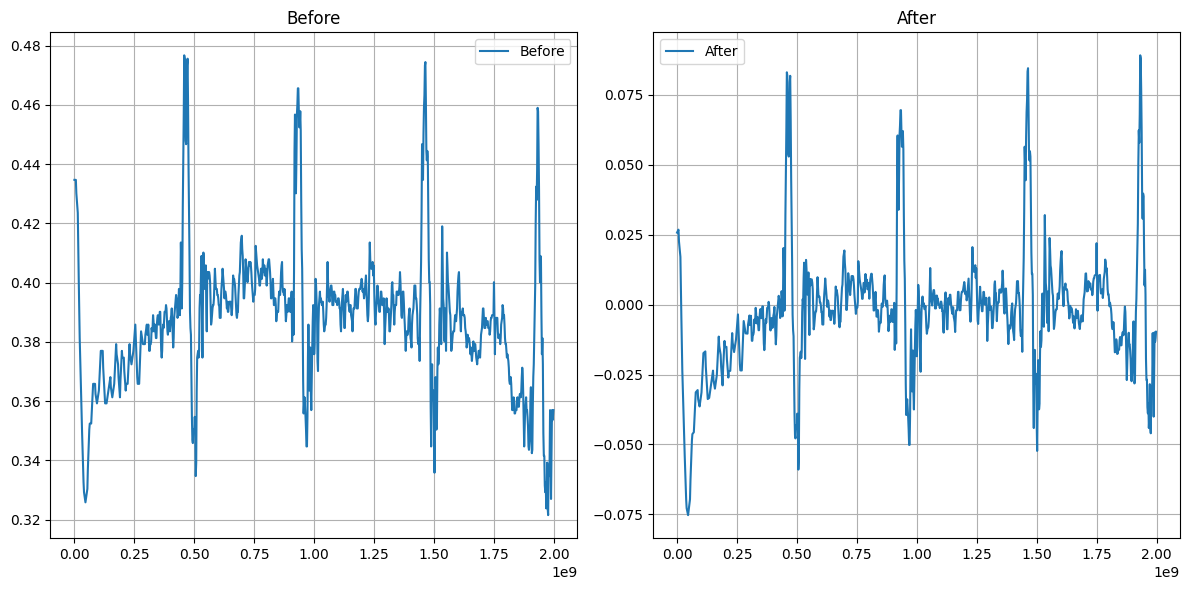

In [101]:
plot(recordDf['II'][:1000],filtered['II'][:1000])

### 3. White noise Removal
A low pass filter was used to remove all the high frequency noises present in the signal. Once again this was done with scipy signal

In [102]:
def removeHighFrequency(ecg_signal,sf):
    sampling_rate = sf  
    cutoff_frequency = 45
    nyquist_rate = sampling_rate / 2

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 

    b, a = signal.butter(4, cutoff_frequency / nyquist_rate, btype='lowpass')
    for i in index:    
        ecg_signal[i] = signal.filtfilt(b, a, ecg_signal[i])
    return ecg_signal

In [103]:
filtered=removeHighFrequency(filtered,fs)

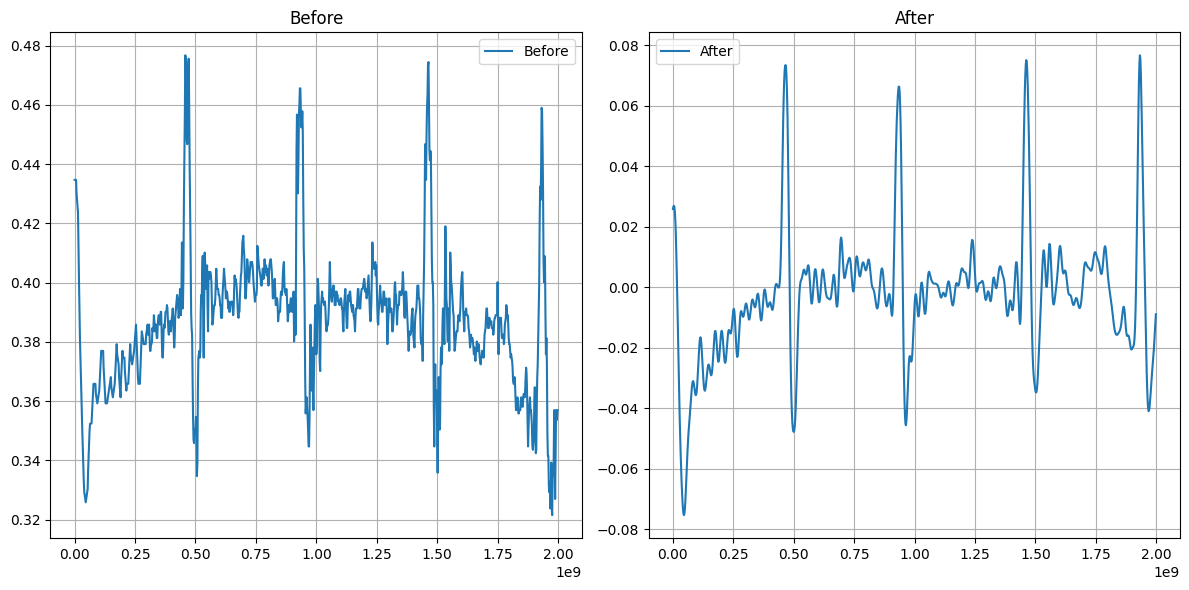

In [104]:
plot(recordDf['II'][:1000],filtered['II'][:1000])

### 4. Discrete and Stationary Wavelet Transformation

This two methods are used in conjuction to remove all robust noise. Use of both methods can be useful to target different types of noise. For this purpose the pywt library was used.

In [105]:
import pywt
import numpy as np  

In [106]:

def SWT(ecg_signal, wavelet,level):
   

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 
    for i in index:
        coeffs = pywt.swt(ecg_signal[i], wavelet, level=level)

        sigma = np.median(np.abs(coeffs[-1])) / 0.6745

        uthresh = sigma * np.sqrt(2 * np.log(len(ecg_signal[i])))
        

        denoised_coeffs = [pywt.threshold(c, uthresh, mode='soft') for c in coeffs]
        

        ecg = pywt.iswt(denoised_coeffs, wavelet)
        ecg_signal[i]=ecg[0].T
    
    return ecg_signal


def DWT(ecg_signal, wavelet,level):
   

    index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 
    for i in index:
        coeffs = pywt.wavedec(ecg_signal[i], wavelet, level=level)

        sigma = np.median(np.abs(coeffs[-1])) / 0.6745

        uthresh = sigma * np.sqrt(2 * np.log(len(ecg_signal[i])))
        

        denoised_coeffs = [pywt.threshold(c, uthresh, mode='soft') for c in coeffs]
        

        ecg_signal[i] = pywt.waverec(denoised_coeffs, wavelet)
    
    return ecg_signal


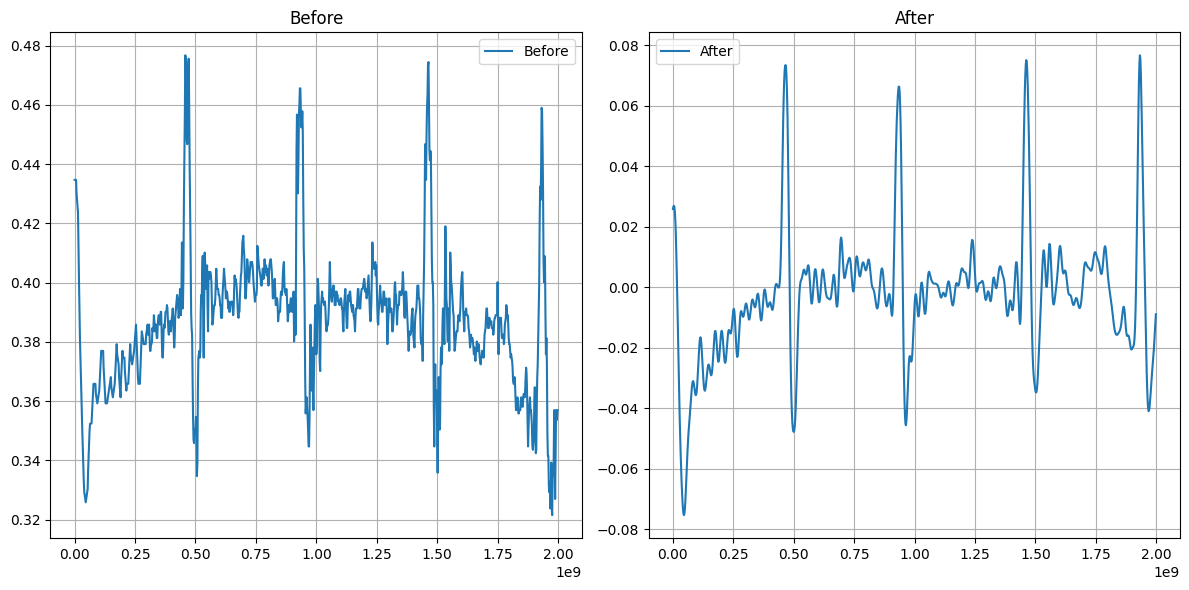

In [107]:
plot(recordDf['II'][:1000],filtered['II'][:1000])

#### All 12 lead Comparison


##### Before

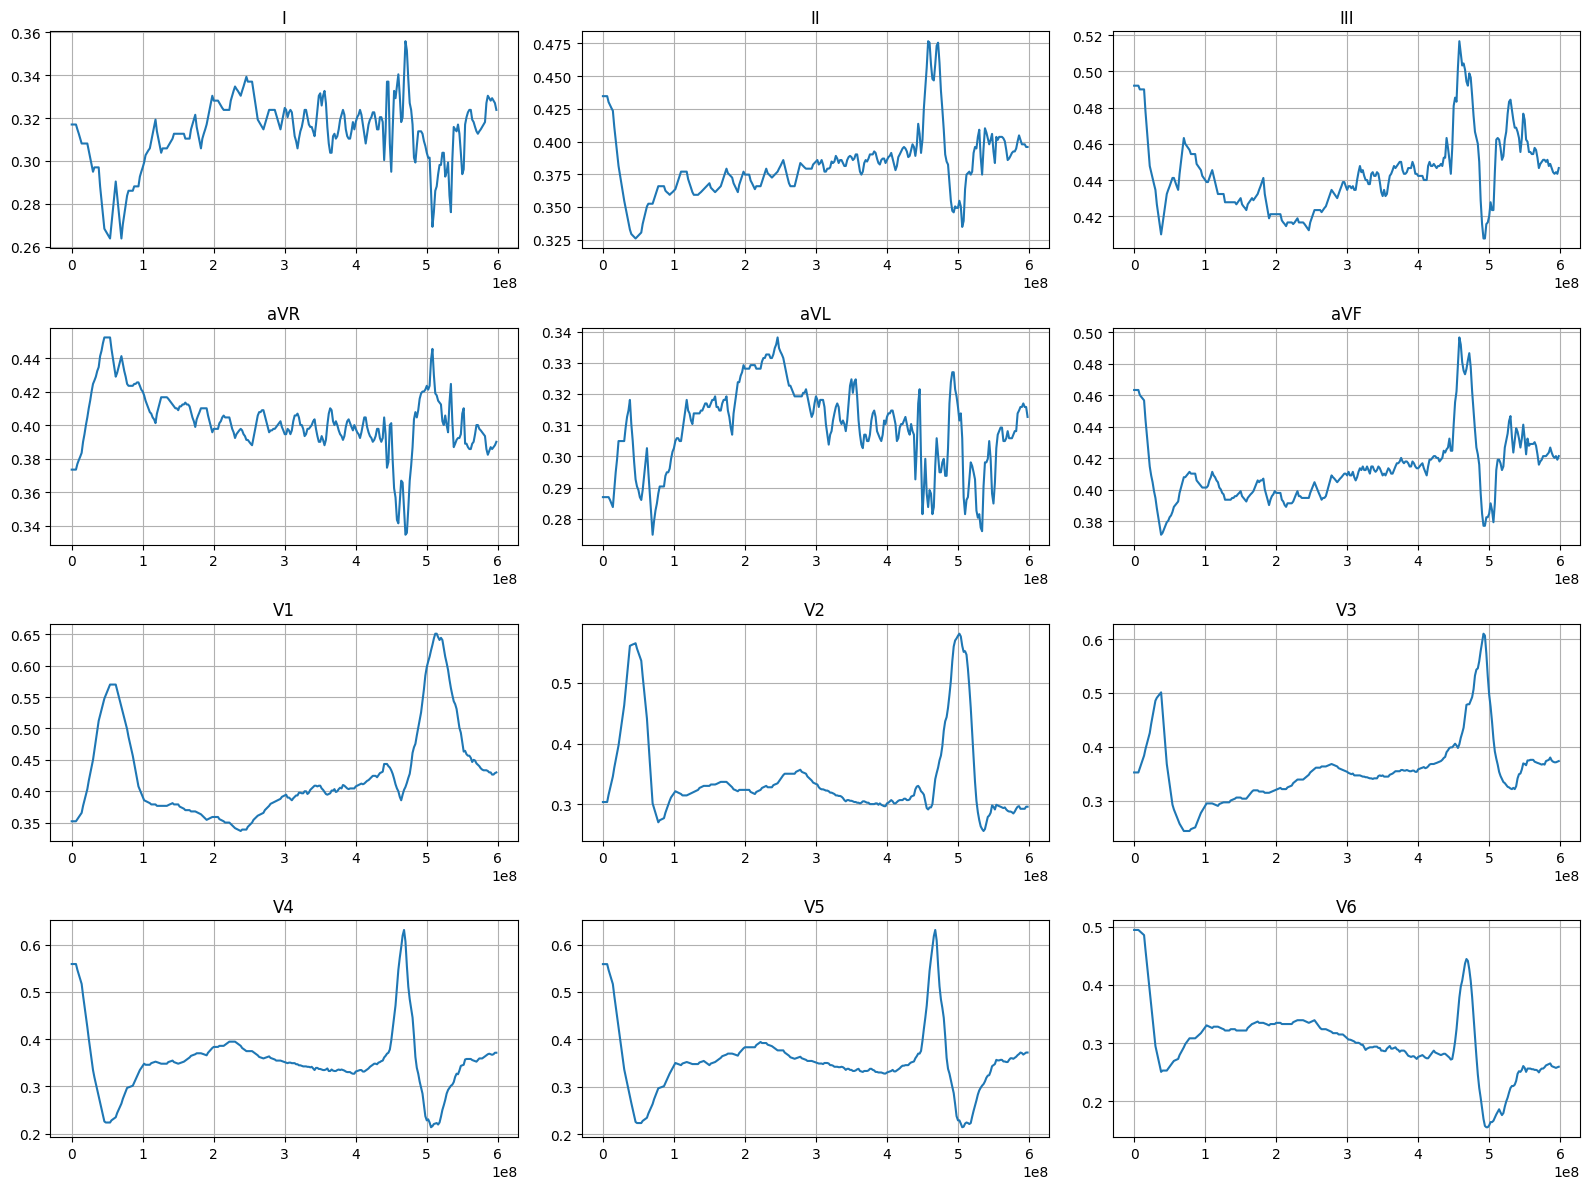

In [108]:
plotLeads(recordDf[:4000],big=True)

##### After

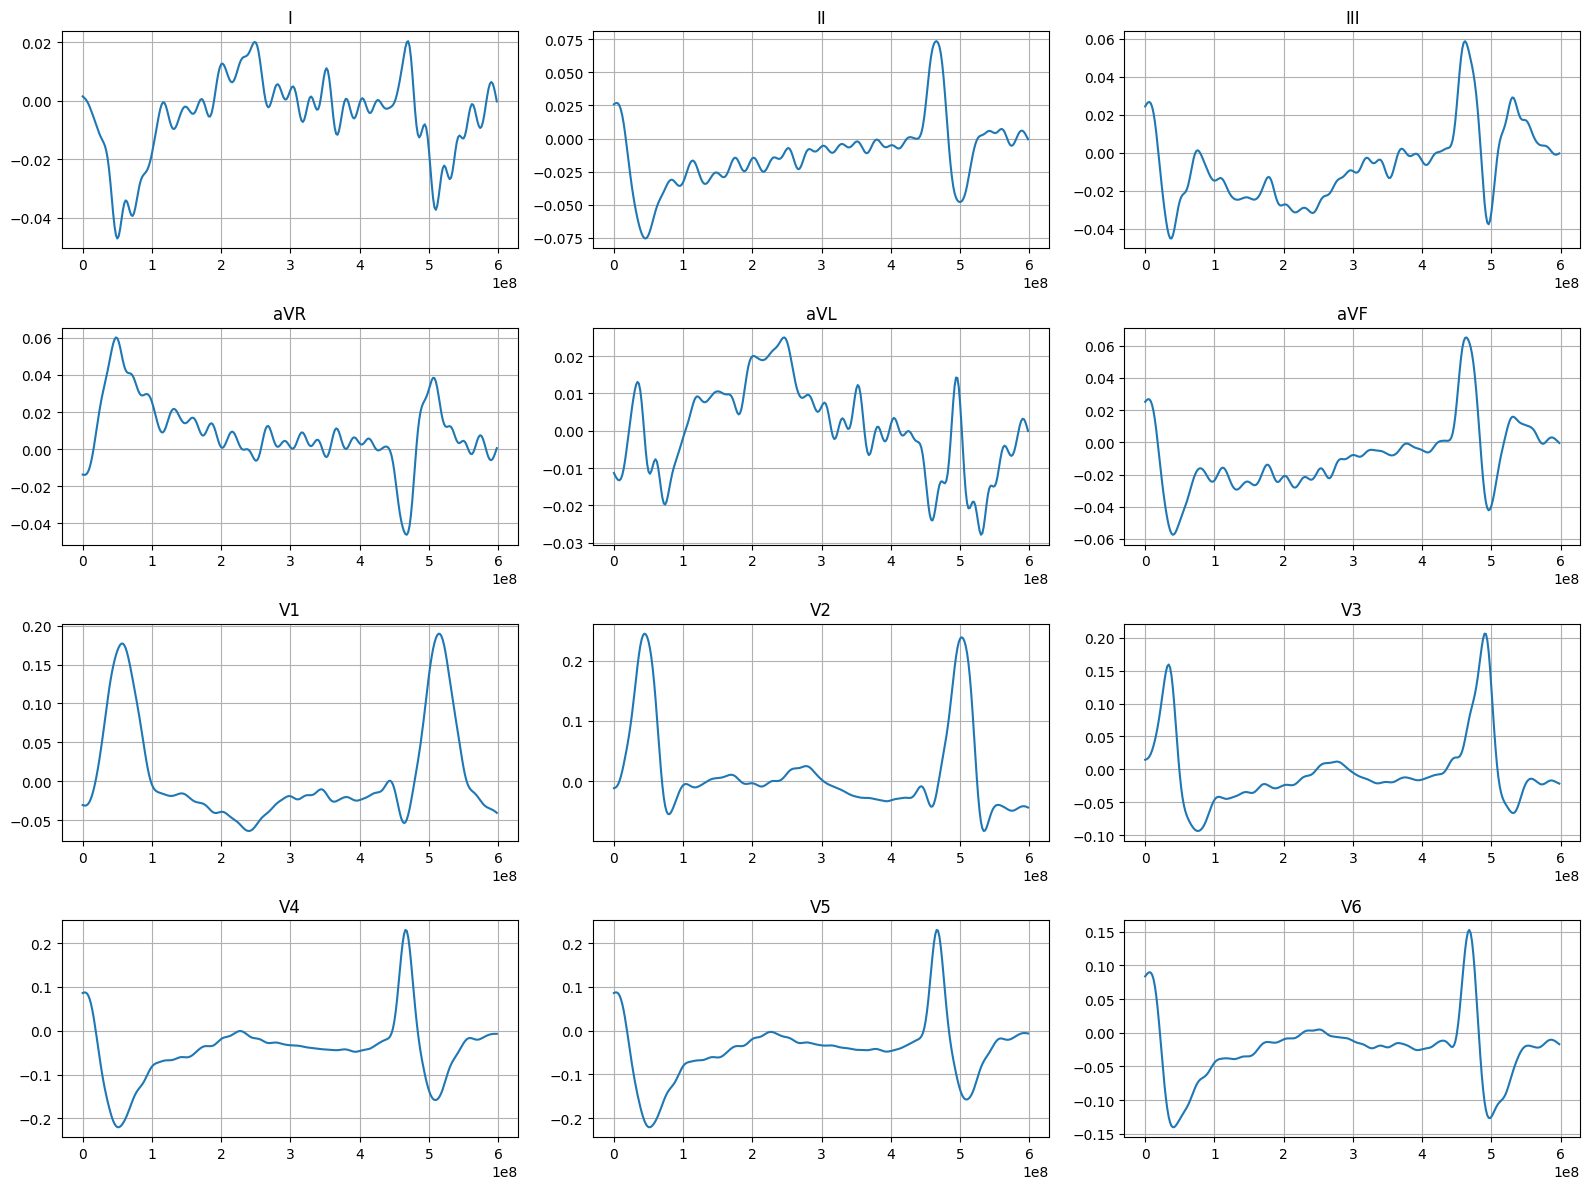

In [109]:
plotLeads(filtered[:4000],big=True)